# Hierarchical Bayesian Modeling of CD8+ T-cell Exhaustion Dynamics in Cancer Using scRNA-seq Data and Markov Chain Monte Carlo

# Part 1: scRNA-seq Data Analysis Pipeline

## Getting Started

### Importing Libraries

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import shutil
import requests
import re
from io import StringIO

### Download Dataset

In [ ]:
# download expression data

# URL of the file to download
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE120575&format=file&file=GSE120575%5FSade%5FFeldman%5Fmelanoma%5Fsingle%5Fcells%5FTPM%5FGEO%2Etxt%2Egz"

# Local file paths
download_path = "./dataset/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz"  # Path to save the downloaded gzipped file
output_path = "./dataset/GSE120575_expression.txt"      # Path to save the uncompressed file

# Download the gzipped file
print("Downloading the file...")
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(download_path, "wb") as file:
        file.write(response.content)
    print(f"File downloaded and saved as '{download_path}'")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Uncompress the file
print("Uncompressing the file...")
with gzip.open(download_path, "rb") as gz_file:
    with open(output_path, "wb") as out_file:
        shutil.copyfileobj(gz_file, out_file)
print(f"File uncompressed and saved as '{output_path}'")


# cleanup expression data
expression_file = "./dataset/GSE120575_expression.txt"

# Open the file and read all lines
with open(expression_file, 'r') as f:
    lines = f.readlines()

# Remove trailing tabs from each line
lines = [re.sub(r'\t+$', '', line.rstrip('\n')) for line in lines]

# Join the lines back into a single string
cleaned_content = '\n'.join(lines)

# Use StringIO to treat the string as a file
cleaned_file = StringIO(cleaned_content)

# Now read the data using pandas
expression_data = pd.read_csv(
    cleaned_file,
    sep='\t',
    header=0,
    skiprows=[1],  # Skip the second row (annotations)
    index_col=0    # Set the first column as the index (gene names)
)

# save the fixed data as csv
expression_data.to_csv('./dataset/GSE120575_expression.csv')

In [ ]:
# download and cleanup metadata

# URL for the file
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE120575&format=file&file=GSE120575%5Fpatient%5FID%5Fsingle%5Fcells%2Etxt%2Egz"

# File name to save the downloaded content
output_file = "./dataset/GSE120575_patient_ID_single_cells.txt.gz"

# Downloading the file
response = requests.get(url)
if response.status_code == 200:
    with open(output_file, "wb") as file:
        file.write(response.content)
    print(f"File downloaded and saved as {output_file}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")
    
# Path to the .gz file
gz_file = "./dataset/GSE120575_patient_ID_single_cells.txt.gz"

# Path to save the decompressed file
output_file = "./dataset/GSE120575_patient_ID_single_cells.txt"

# Decompress the .gz file
with gzip.open(gz_file, 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"File decompressed and saved as {output_file}")


# Path to the file
file_path = "./dataset/GSE120575_patient_ID_single_cells.txt"
output_path = "./dataset/GSE120575_metadata.csv"  # Path to save the cleaned file

# Load the data, specifying the correct encoding and skipping rows
try:
    data = pd.read_csv(file_path, sep="\t", encoding='latin1', skiprows=19)  # Skip first 19 rows
except UnicodeDecodeError:
    raise ValueError("Failed to decode the file with 'latin1'. Please check the file encoding.")

# Remove the last 38 rows
data = data.iloc[:-38, :]

# Drop Unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Save the cleaned data in UTF-8 format
data.to_csv(output_path, index=False, encoding='utf-8')

print(f"Cleaned metadata saved as '{output_path}' in UTF-8 format.")

### Load Dataset

In [21]:
# File paths
expression_file = "./dataset/GSE120575_expression.csv"
metadata_file = "./dataset/GSE120575_metadata.csv"

In [22]:
# Expression Data: a matrix of single cells and corresponding gene expressions
expression_data = pd.read_csv(expression_file, index_col=0)

# Transpose the data to have cells as rows and genes as columns
expression_data = expression_data.T

# Display the shape and the first few rows to confirm the loading
print("Expression Data Shape:", expression_data.shape)
print(expression_data.head())

Expression Data Shape: (16291, 55737)
            TSPAN6  TNMD  DPM1  SCYL3  C1orf112  FGR  CFH  FUCA2  GCLC  NFYA  \
A10_P3_M11     0.0   0.0  0.00    0.0       0.0  0.0  0.0    0.0  0.00   0.0   
A11_P1_M11     0.0   0.0  9.24    0.0       0.0  0.0  0.0    0.0  1.01   0.0   
A11_P3_M11     0.0   0.0  0.00    0.0       0.0  0.0  0.0    0.0  0.00   0.0   
A11_P4_M11     0.0   0.0  7.99    0.0       0.0  0.0  0.0    0.0  0.00   0.0   
A12_P3_M11     0.0   0.0  0.00    0.0       0.0  0.0  0.0    0.0  0.00   0.0   

            ...  RP11-126K1.9  RP4-671G15.2  OR6R2P  RP11-225H22.7  \
A10_P3_M11  ...           0.0           0.0     0.0            0.0   
A11_P1_M11  ...           0.0           0.0     0.0            0.0   
A11_P3_M11  ...           0.0           0.0     0.0            0.0   
A11_P4_M11  ...           0.0           0.0     0.0            0.0   
A12_P3_M11  ...           0.0           0.0     0.0            0.0   

            RP11-731C17.2  RP4-621B10.8  RP11-114I8.4  RP11-

In [23]:
# Metadata: maps cells to patient IDs and additional information
metadata = pd.read_csv(metadata_file, index_col=1)  # index is the column containing cell IDs
print("Metadata Shape:", metadata.shape)
print(metadata.head())

Metadata Shape: (16291, 10)
           Sample name           source name      organism  \
title                                                        
A10_P3_M11    Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11    Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11    Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11    Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11    Sample 5  Melanoma single cell  Homo sapiens   

           characteristics: patinet ID (Pre=baseline; Post= on treatment)  \
title                                                                       
A10_P3_M11                                             Pre_P1               
A11_P1_M11                                             Pre_P1               
A11_P3_M11                                             Pre_P1               
A11_P4_M11                                             Pre_P1               
A12_P3_M11                                             Pre_P1              

In [24]:
# Ensure Alignment Between Expression Data and Metadata

# Ensure that the indices match
common_cells = expression_data.index.intersection(metadata.index)

# Subset the data to include only common cells
expression_data = expression_data.loc[common_cells]
metadata = metadata.loc[common_cells]

print("Number of Common Cells:", len(common_cells))


Number of Common Cells: 16291


### Converting to AnnData Object

In [108]:
# Create AnnData object
adata = sc.AnnData(X=expression_data.values)

# Assign cell IDs and gene names
adata.obs_names = expression_data.index
adata.var_names = expression_data.columns

# Add metadata to .obs
adata.obs = metadata

print(adata)

AnnData object with n_obs × n_vars = 16291 × 55737
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'


In [109]:
# save data
adata.write('./dataset/adata.h5ad')

# Quality Control

In [110]:
def data_quality_control_check(adata):
    """
    Perform quality control (QC) analysis on an AnnData object used in scRNA-seq data analysis.

    This function calculates and adds QC metrics to the AnnData object for each cell. These metrics include 
    the total counts of RNA molecules per cell, the number of detected genes, and the fraction of 
    mitochondrial (MT) genes. It also generates violin plots and scatter plots for these metrics to assist 
    in determining appropriate threshold values for further quality control filtering.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing scRNA-seq data. This object should have cells as rows and genes as columns.
    
    Returns:
    --------
    adata : AnnData
        The modified AnnData object with added QC metrics. The metrics added are 'n_genes_by_counts' (number of 
        genes detected in each cell), 'total_counts' (total number of RNA molecules detected per cell), and 
        'pct_counts_mt' (percentage of counts belonging to mitochondrial genes).

    Description:
    ------------
    The function identifies mitochondrial genes by checking if their names start with 'MT-'. It then calculates 
    the total RNA molecule counts, the number of genes detected, and the fraction of counts from mitochondrial 
    genes for each cell. 

    The function uses Scanpy's `calculate_qc_metrics` to compute these metrics and adds them to the AnnData 
    object. It also generates violin plots for the number of genes, total counts, and mitochondrial gene 
    percentage, as well as scatter plots to visualize the relationship between total counts and the number 
    of genes, and total counts versus mitochondrial gene percentage. These plots are essential for assessing 
    the quality of the data and deciding on thresholds for filtering out low-quality cells.
    """

    # Identify and annotate mitochondrial genes, which start with MT in their ID
    adata.var['mt'] = adata.var_names.str.startswith('MT-')

    # Verify mitochondrial gene annotation
    if 'mt' not in adata.var.columns or adata.var['mt'].sum() == 0:
        print("Warning: No mitochondrial genes detected with 'MT-' prefix. Please check the annotation.")

    # Calculate quality check metrics, particularly: total counts, no. of genes, and MT genes fraction
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
    
    # Produce a violin plot for the quality check metrics 
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
    
    # Produce scatter plots for total count vs mitochondrial genes and gene count
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    
    return adata

In [111]:
def data_quality_control_apply(adata, min_counts, max_counts, min_genes, max_genes, max_pct_mt):
    
    """
    Apply a series of quality control filters to an AnnData object from scRNA-seq data.

    This function performs several filtering steps to remove low-quality cells based on specified 
    criteria: the maximum total counts, the minimum and maximum number of genes expressed, and the 
    maximum percentage of mitochondrial gene counts. The function prints the number of cells in the 
    dataset after each filtering step for tracking the impact of each criterion.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing single-cell RNA sequencing data, with cells as rows and genes as columns.
    max_counts : int
        Maximum allowed total counts (sum of all gene expression counts) per cell. Cells exceeding this 
        threshold will be filtered out.
    min_genes : int
        Minimum number of genes that must be expressed in a cell. Cells with fewer expressed genes will 
        be filtered out.
    max_genes : int
        Maximum number of genes that must be expressed in a cell. Cells with more expressed genes will 
        be filtered out.
    max_pct_mt : float
        Maximum allowed percentage of mitochondrial gene counts. Cells with a higher percentage will be 
        filtered out.

    Returns:
    --------
    AnnData
        The filtered AnnData object.

    Description:
    ------------
    The function begins by filtering genes that are detected in at least a minimum number of cells.
    It then applies a series of cell-level filters based on total counts, number of genes expressed, 
    and mitochondrial gene expression. These filters help in identifying and removing potential outliers 
    or cells with poor-quality data, such as dying cells (often indicated by high mitochondrial content) 
    or empty droplets.

    """
    
    # Number of cells before any filtering
    print('Total number of cells before filtering: {:d}'.format(adata.n_obs))
    
    # Filter out counts over min_counts
    sc.pp.filter_cells(adata, min_counts = min_counts)
    print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
    
    # Filter out counts over max_counts
    sc.pp.filter_cells(adata, max_counts = max_counts)
    print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

    # Filter out cells with under min_genes genes
    sc.pp.filter_cells(adata, min_genes = min_genes)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

    #Filter out cells with over max_genes genes
    sc.pp.filter_cells(adata, max_genes = max_genes)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
    
    # Filter out cells with high percentage of mitochondrial genes
    #adata = adata[adata.obs.pct_counts_mt < max_pct_mt, :].copy()
    adata = adata[adata.obs['pct_counts_mt'] < max_pct_mt].copy()

    print('Number of cells after MT pct filter: {:d}'.format(adata.n_obs))
    
    return adata

/usr4/spclpgm/myousry/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


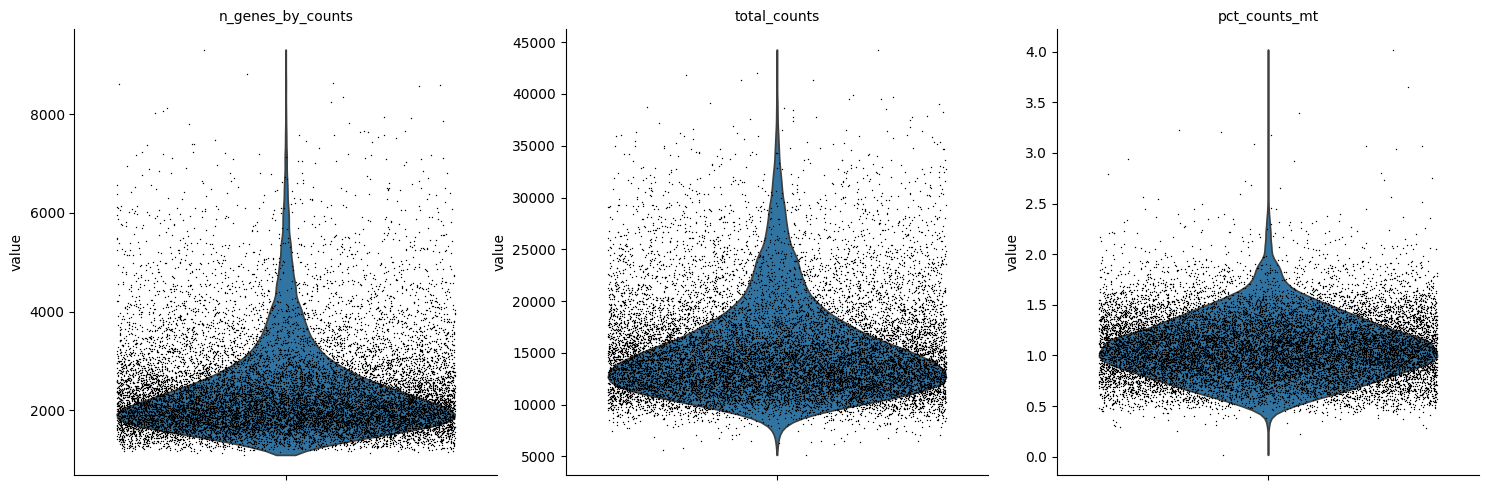

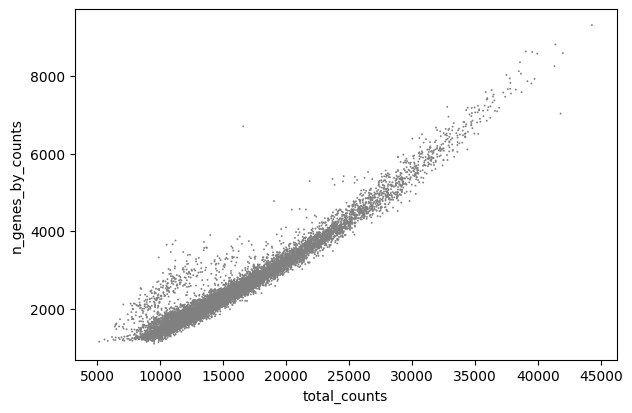

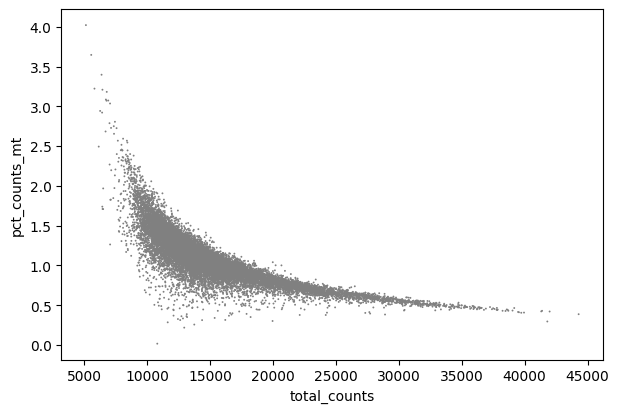

AnnData object with n_obs × n_vars = 16291 × 55737
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [112]:
# check data quality
data_quality_control_check(adata)

In [113]:
# filter data
adata = data_quality_control_apply(adata, min_counts=7000, max_counts=40000, min_genes=200, max_genes=8000, max_pct_mt=5)

Total number of cells before filtering: 16291
Number of cells after min count filter: 16274
Number of cells after max count filter: 16269
Number of cells after gene filter: 16269
Number of cells after gene filter: 16262
Number of cells after MT pct filter: 16262


/usr4/spclpgm/myousry/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


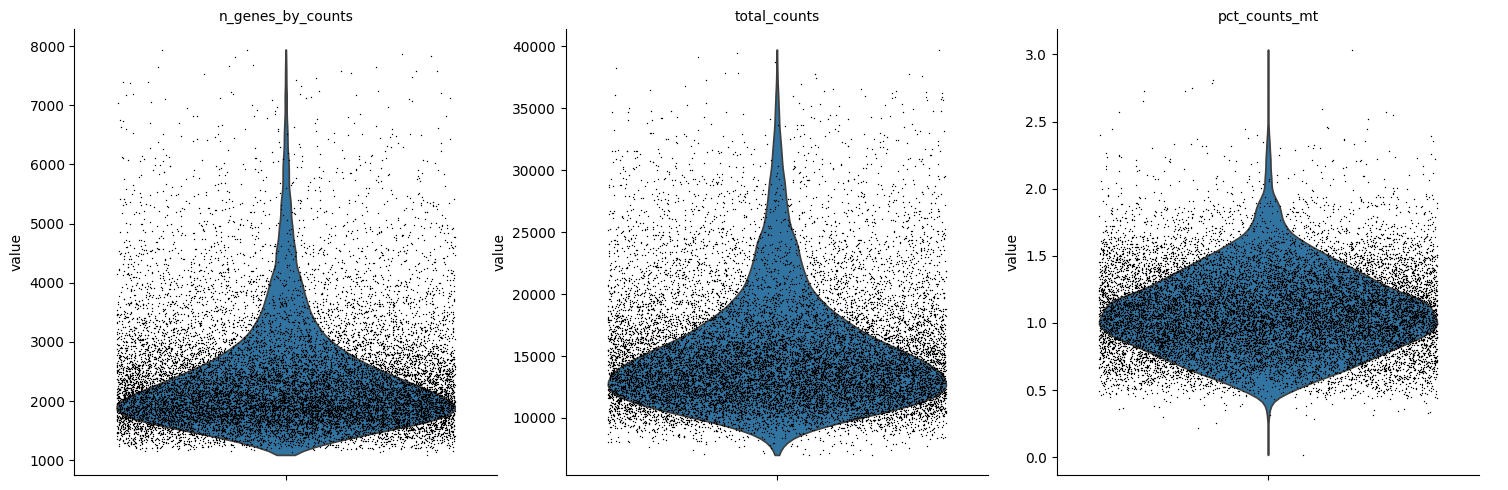

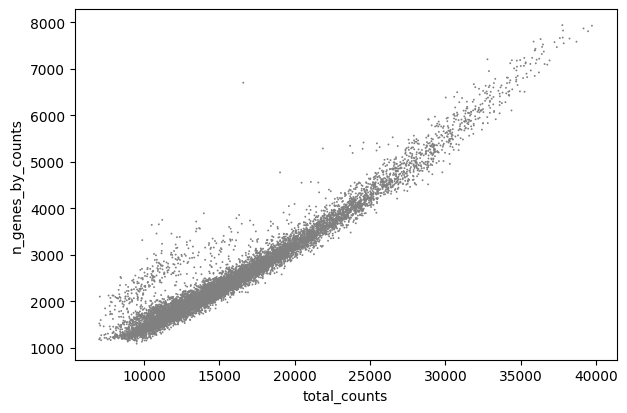

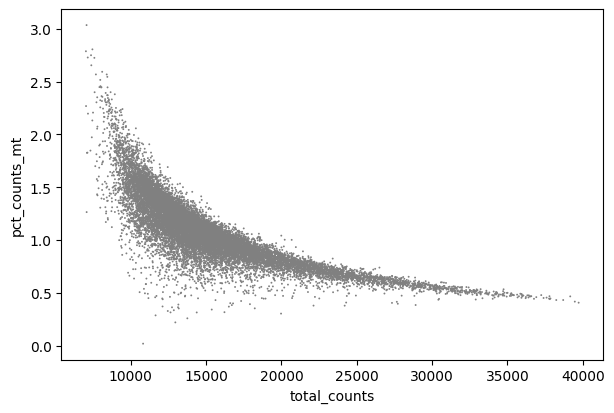

AnnData object with n_obs × n_vars = 16262 × 55737
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [114]:
# recheck data quality
data_quality_control_check(adata)

In [115]:
# save cleaned data
adata.write('./dataset/adata_qc.h5ad')

## Preprocessing

### Transformation

In [34]:
# Normalizing

# Keep the count data in a counts layer.
adata.layers["counts"] = adata.X.copy()

# Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell.
sc.pp.normalize_total(adata, target_sum=1e4)

In [35]:
# Logarithmizing

# Logarithmize the data
sc.pp.log1p(adata)

# Save the normalized and logarithmized raw data in the .raw attribute of the anndata.
adata.raw = adata

### Identify highly-variable genes

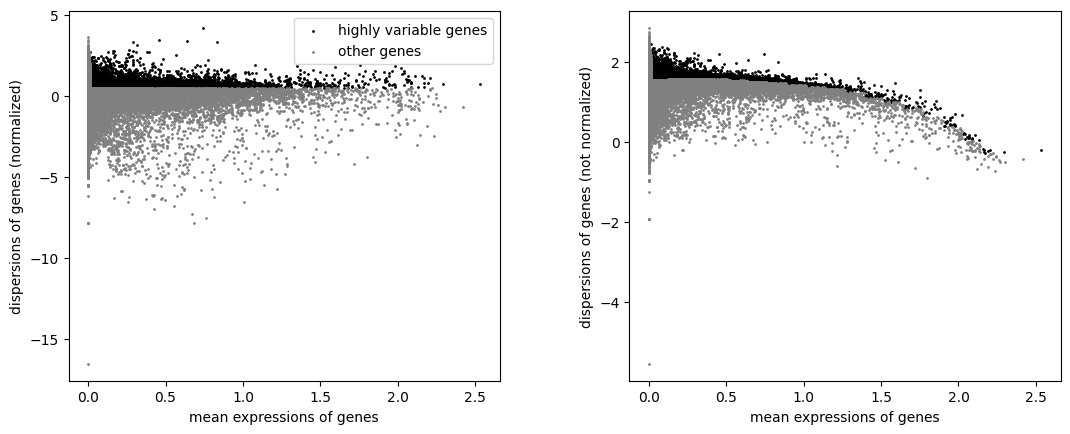

In [36]:
# Extracting highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Visualization of highly variable genes
sc.pl.highly_variable_genes(adata)

# Get only highly variable genes
adata = adata[:, adata.var.highly_variable]

###  Regress out confoundings and Scaling

In [37]:
# Regress out the effect of total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scaling the data to unit variance and clip values above standard deviation of 10.
sc.pp.scale(adata, max_value=10)

/usr4/spclpgm/myousry/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Processing

### PCA

In [58]:
# Performing Principal Component Analysis (PCA)
sc.pp.pca(adata, n_comps=200, use_highly_variable=True, svd_solver='arpack')

/usr4/spclpgm/myousry/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


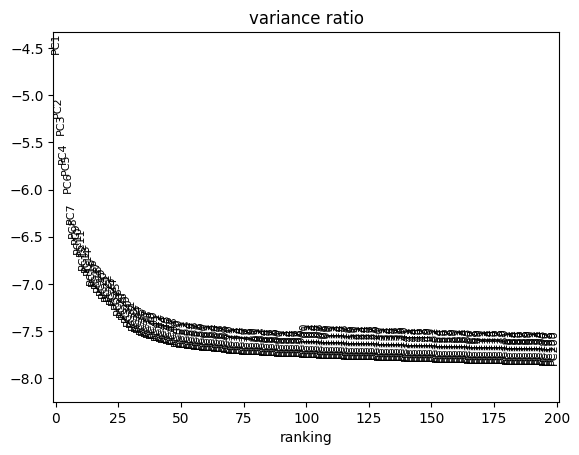

In [59]:
# Visualize elbow plot for the variance ratio across principal components
sc.pl.pca_variance_ratio(adata, n_pcs=200, log=True)

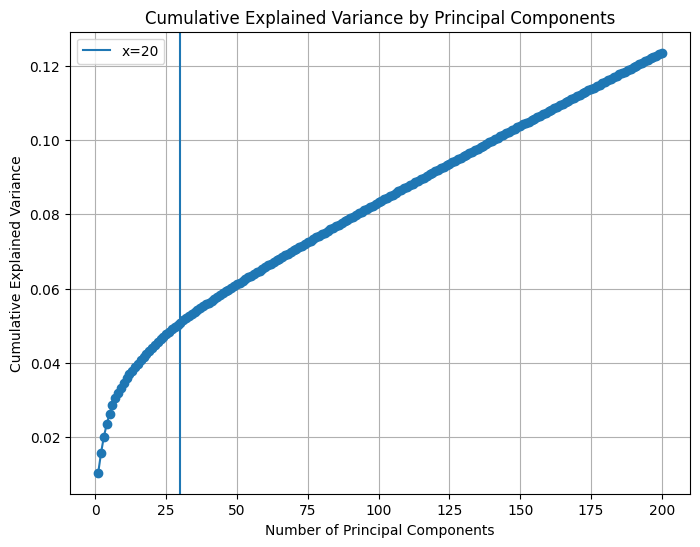

In [60]:
explained_variance_ratio = adata.uns['pca']['variance_ratio']
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.axvline(x=30, label='x=30')
plt.grid()
plt.legend()
plt.show()

### Neighborhood Graph

In [61]:
# Calculate the neighborhood graph with 50 PCs. 
sc.pp.neighbors(adata, n_pcs=30) # n_neighbors = 15 by default.

### UMAP

In [62]:
# UMAP calculation
sc.tl.umap(adata)  # min_dist = 0.5 by default

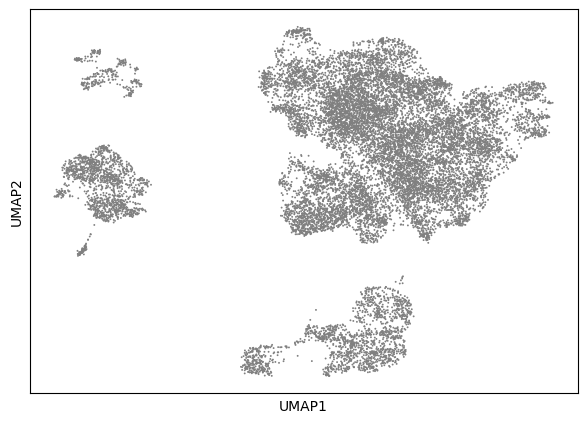

In [65]:
# Visualize the UMAP with highlighting the different five samples in the dataset
sc.pl.scatter(adata, basis='umap')

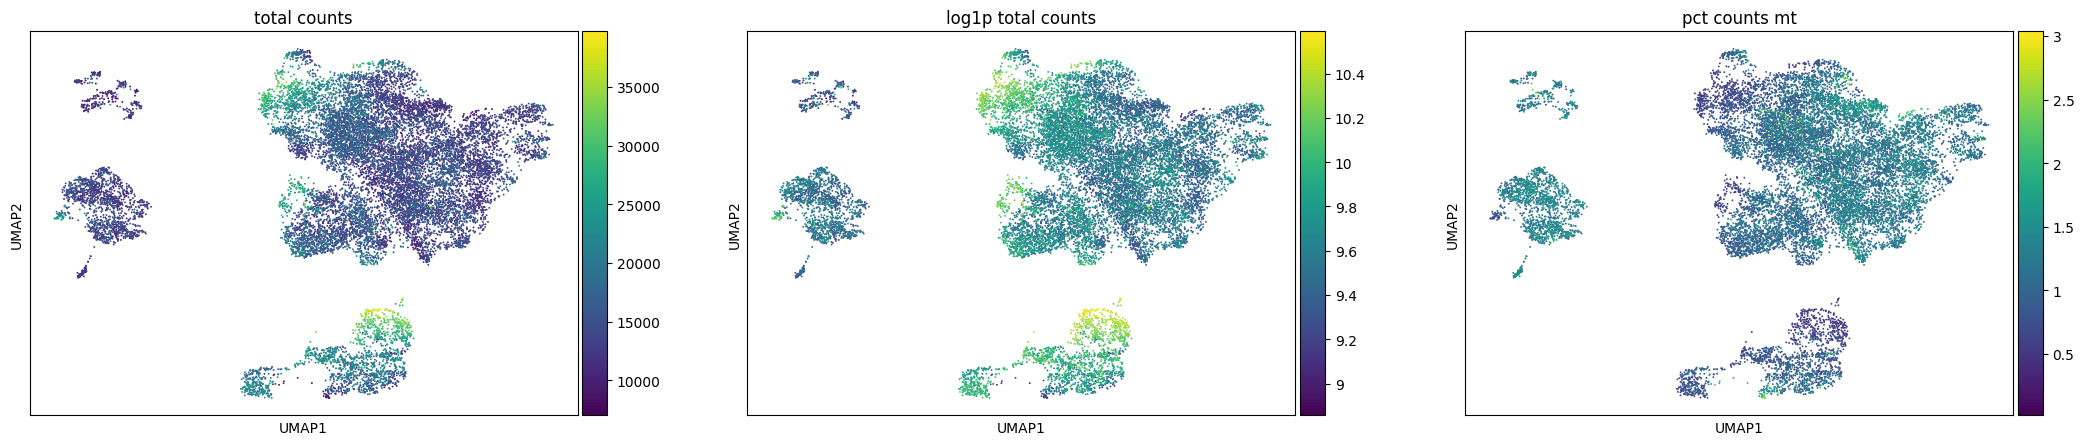

In [75]:
# Visualize the distribution of data quality metrics in the UMAP
sc.pl.scatter(adata, basis='umap', color=[ 'total_counts', 'log1p_total_counts', 'pct_counts_mt'])

## Isolating CD8+ T Cells

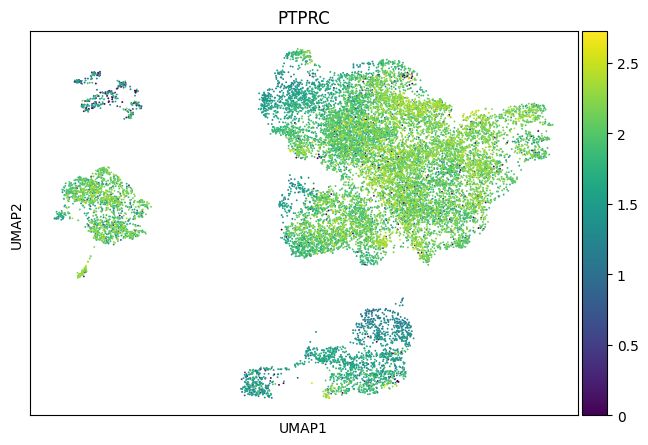

In [68]:
# Marker gene for all immune cells
sc.pl.scatter(adata, basis='umap', color='PTPRC')

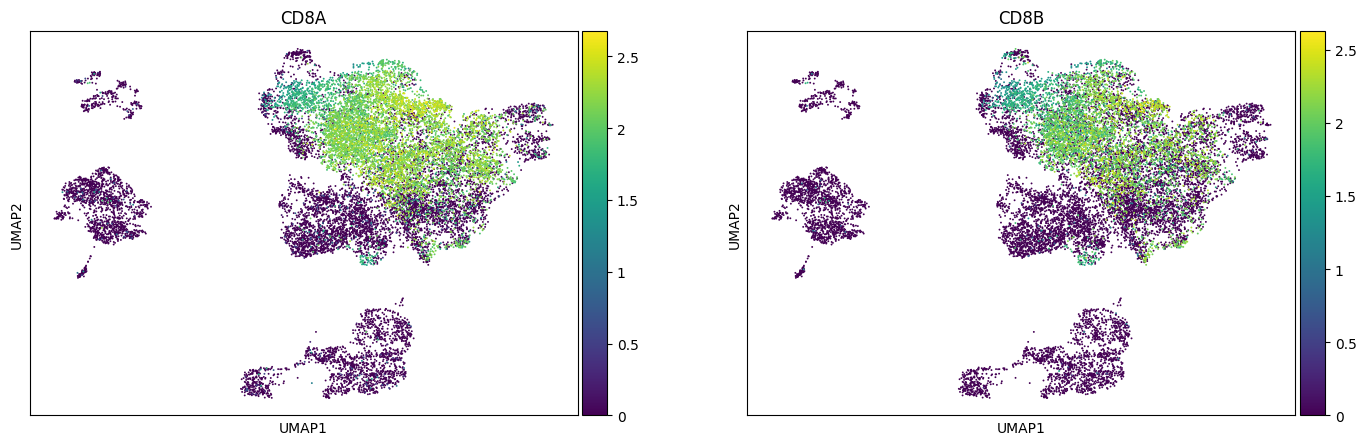

In [77]:
# Marker gene specific for CD8+ T cells
sc.pl.scatter(adata, basis='umap', color=['CD8A','CD8B'])

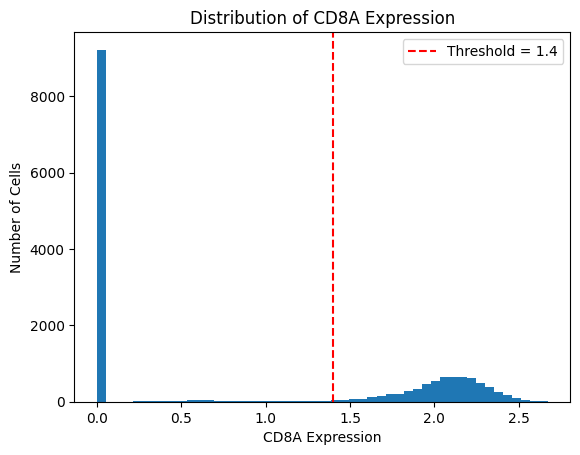

In [98]:
# Histogram
# Extract CD8A expression values from the raw data
cd8a_expression = adata.raw[:, 'CD8A'].X.flatten()

# Plot the distribution of CD8A expression values
plt.hist(cd8a_expression, bins=50)
plt.axvline(x=1.4, color='r', linestyle='--', label='Threshold = 1.4')
plt.xlabel('CD8A Expression')
plt.ylabel('Number of Cells')
plt.title('Distribution of CD8A Expression')
plt.legend()
plt.show()

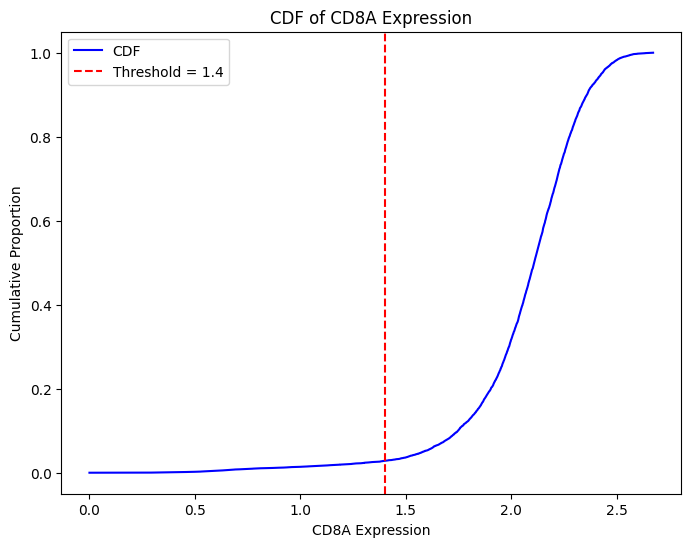

In [99]:
# CDF
# Sort the expression values
sorted_expression = np.sort(cd8a_expression)

# Compute the CDF
cdf = np.cumsum(sorted_expression) / np.sum(sorted_expression)

# Plot the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_expression, cdf, label='CDF', color='blue')
plt.axvline(x=1.4, color='red', linestyle='--', label='Threshold = 1.4')
plt.xlabel('CD8A Expression')
plt.ylabel('Cumulative Proportion')
plt.title('CDF of CD8A Expression')
plt.legend()
plt.show()


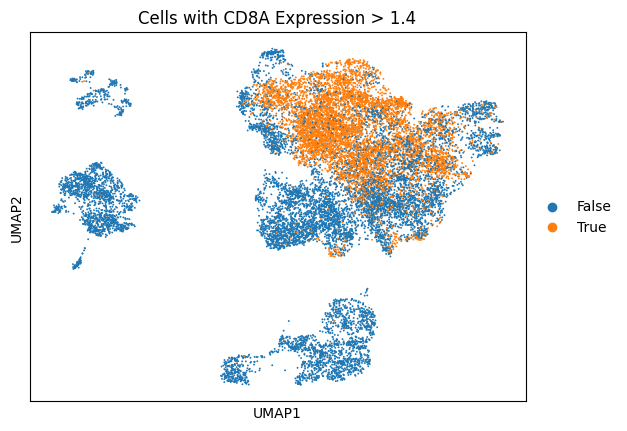

In [100]:
# Threshold based on Histogram and CDF plot inspection
threshold = 1.4

# Create a boolean mask for cells with CD8A expression above the threshold
cd8_tcells_mask = cd8a_expression > threshold

# Add this mask as a new observation in the AnnData object
adata.obs['CD8A_high'] = cd8_tcells_mask

# Plot the UMAP with the cells expressing higher than the threshold highlighted
sc.pl.umap(adata, color='CD8A_high', title='Cells with CD8A Expression > 1.4')

In [102]:
# Subset the AnnData object based on the raw data mask
cd8_adata = adata[cd8_tcells_mask].copy()

cd8_adata

AnnData object with n_obs × n_vars = 6557 × 6885
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'CD8A_high'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'CD8A_high_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [104]:
# Extract the barcodes of the filtered cells
cd8_barcodes = cd8_adata.obs_names

# Verify the barcodes
print(f"Number of CD8+ T cell barcodes: {len(cd8_barcodes)}")

Number of CD8+ T cell barcodes: 6557


In [129]:
# Reading the original raw cleaned AnnData dataset as adata
file_path = './dataset/adata_qc.h5ad'
adata_raw = sc.read_h5ad(file_path)

# Subset the unprocessed dataset to include only CD8+ T cells
cd8_adata = adata_raw[cd8_barcodes, :]

# Verify the raw subset
cd8_adata

View of AnnData object with n_obs × n_vars = 6557 × 55737
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [130]:
# save data
cd8_adata.write('./dataset/cd8_adata.h5ad')

In [2]:
# loading data
file_path = './dataset/cd8_adata.h5ad'
cd8_adata = sc.read_h5ad(file_path)

### Preprocessing

#### Transformation

In [3]:
# Normalization

# Keep the count data in a counts layer.
cd8_adata.layers["counts"] = cd8_adata.X.copy()

# Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell.
sc.pp.normalize_total(cd8_adata, target_sum=1e4)

In [4]:
# Logarithmizing

# Logarithmize the data
sc.pp.log1p(cd8_adata)

# Save the normalized and logarithmized raw data in the .raw attribute of the anndata.
cd8_adata.raw = cd8_adata

#### Highly Variable Genes

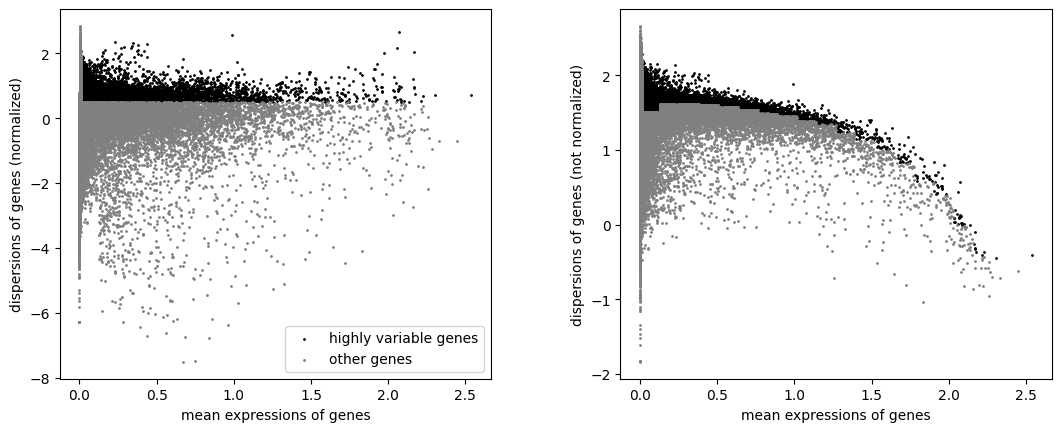

In [5]:
# Extracting highly variable genes
sc.pp.highly_variable_genes(cd8_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Visualization of highly variable genes
sc.pl.highly_variable_genes(cd8_adata)

# Get only highly variable genes
cd8_adata = cd8_adata[:, cd8_adata.var.highly_variable]

#### Counfoundings and Scaling

In [6]:
# Regress out the effect of total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(cd8_adata, ['total_counts', 'pct_counts_mt'])

# Scaling the data to unit variance and clip values above standard deviation of 10.
sc.pp.scale(cd8_adata, max_value=10)

/usr4/spclpgm/myousry/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Processing

#### PCA

In [7]:
# Performing Principal Component Analysis (PCA)
sc.tl.pca(cd8_adata, n_comps=100, svd_solver='arpack')

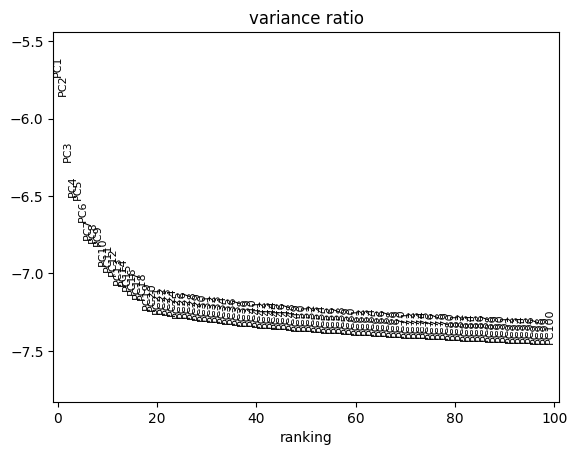

In [8]:
# Visualize elbow plot for the variance ratio across principal components
sc.pl.pca_variance_ratio(cd8_adata,n_pcs=100, log=True)

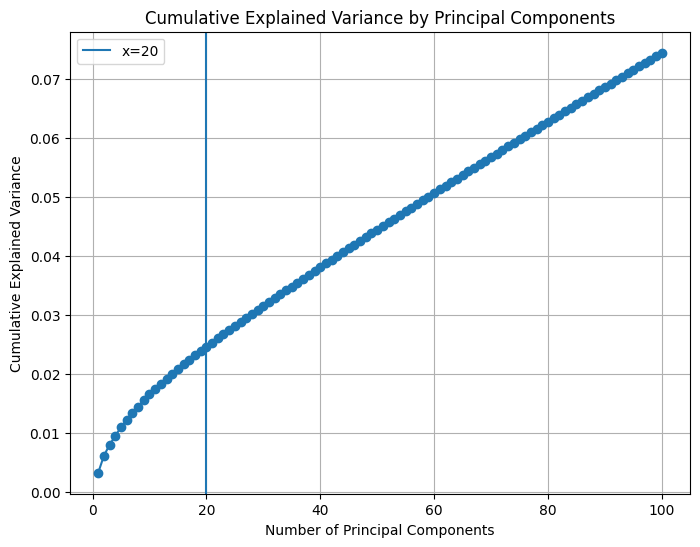

In [9]:
explained_variance_ratio = cd8_adata.uns['pca']['variance_ratio']
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.axvline(x=20, label='x=20')
plt.grid()
plt.legend()
plt.show()

#### Neighborhood Graph Construction

In [6]:
# Calculate the neighborhood graph with 20 PCs. 
sc.pp.neighbors(cd8_adata, n_pcs=20) # n_neighbors = 15 by default.

/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/

#### UMAP

In [7]:
# UMAP calculation
sc.tl.umap(cd8_adata) # min_dist = 0.5 by default

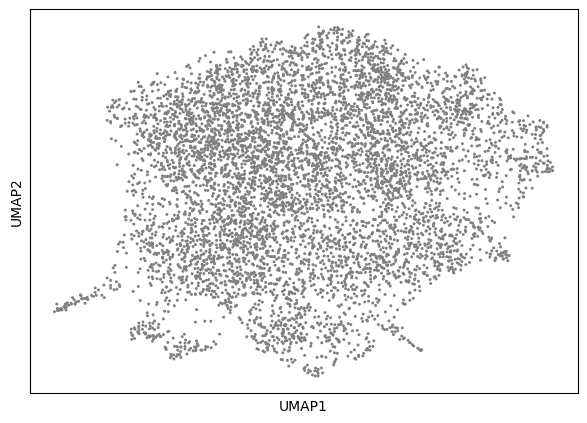

In [8]:
# Visualize the UMAP with highlighting the different five samples in the dataset
sc.pl.scatter(cd8_adata, basis='umap')

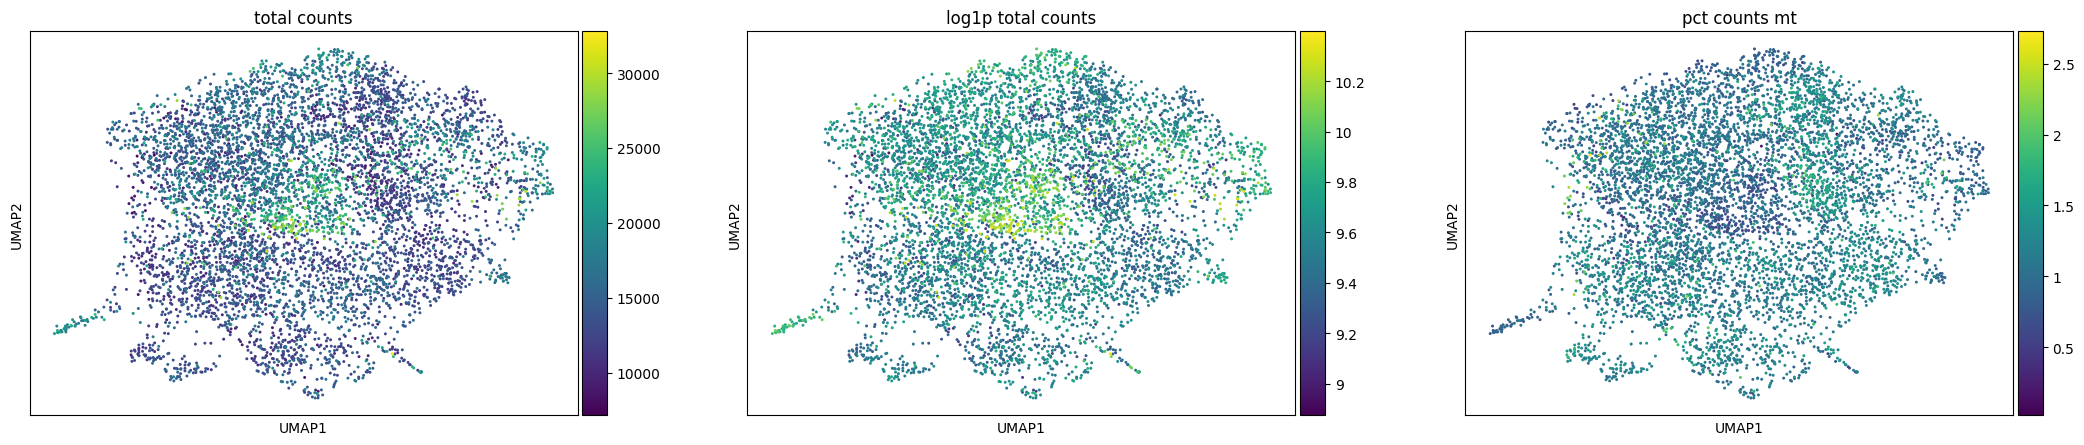

In [14]:
# Visualize the distribution of data quality metrics in the UMAP
sc.pl.scatter(cd8_adata, basis='umap', color=[ 'total_counts', 'log1p_total_counts', 'pct_counts_mt'])

In [12]:
# save data
cd8_adata.write('./dataset/cd8_adata_processed.h5ad')

In [5]:
# loading data
file_path = './dataset/cd8_adata_processed.h5ad'
cd8_adata = sc.read_h5ad(file_path)

### Marker Genes

In [ ]:
# Memory
sc.pl.scatter(cd8_adata, basis='umap', color=['GZMK', 'CD44', 'CXCR3'])

In [ ]:
# naive
sc.pl.scatter(cd8_adata, basis='umap', color=['CCR7', 'TCF7'])

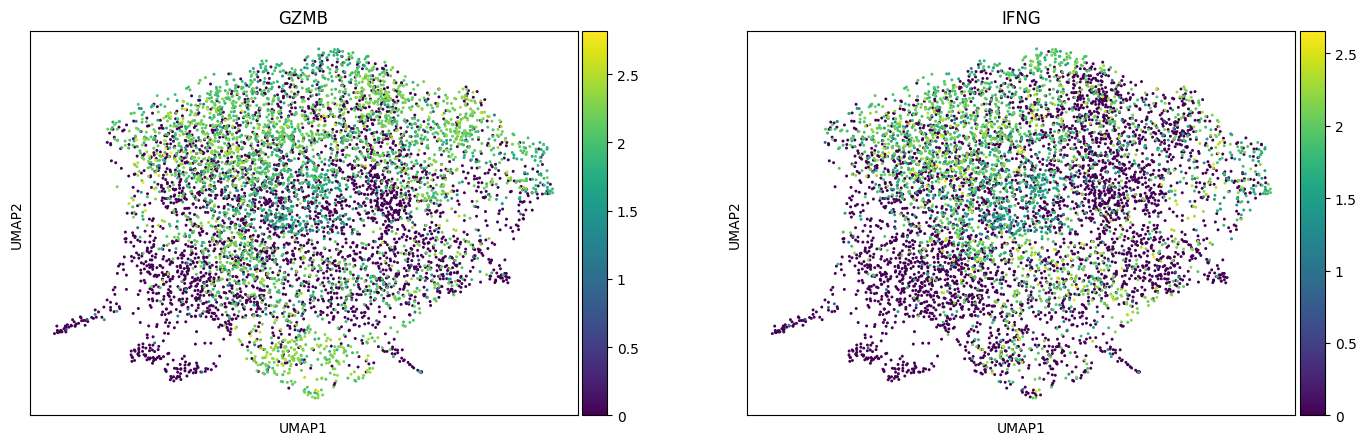

In [23]:
# Effector
sc.pl.scatter(cd8_adata, basis='umap', color=['GZMB', 'IFNG'])

In [ ]:
# Progenitor Exhausted
sc.pl.scatter(cd8_adata, basis='umap', color=['LEF1', 'SLAMF6'])

In [ ]:
# Terminally Exhausted
sc.pl.scatter(cd8_adata, basis='umap', color=['PDCD1', 'TIGIT', 'HAVCR2'])

### Gene Signatures

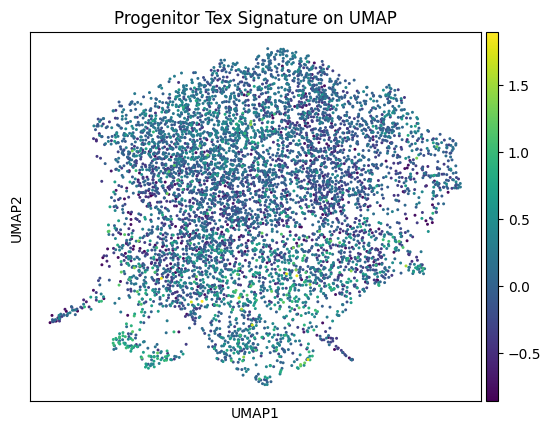

In [22]:
# Progenitor exhausted cell signature
progenitor_ex_genes = ["TCF7", "LEF1", "CXCR5", "IL7R", "SELL", "GZMB", "PRF1", "IFNG", "CD28", "SLAMF6"]

# Filter valid genes in the dataset
progenitor_ex_genes_valid = [gene for gene in progenitor_ex_genes if gene in cd8_adata.var_names]

# Compute the average expression of the progenitor Tex signature
cd8_adata.obs['progenitor_ex_score'] = cd8_adata[:, progenitor_ex_genes_valid].X.mean(axis=1)

# Plot the UMAP with the progenitor Tex signature score
sc.pl.umap(cd8_adata, color='progenitor_ex_score', title='Progenitor exhausted Signature on UMAP', cmap='viridis')

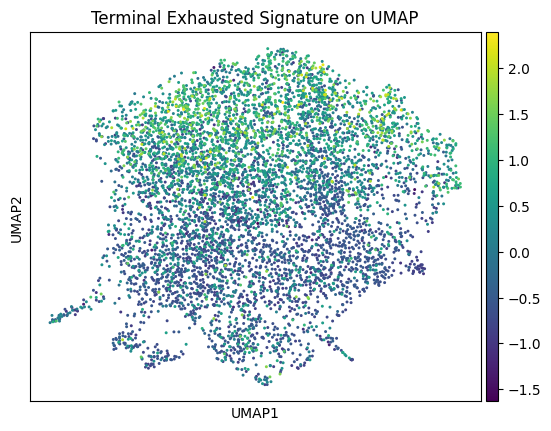

In [26]:
# Terminally exhausted T cell signature
terminal_ex_genes = ["PDCD1", "LAG3", "HAVCR2", "TIGIT", "TOX", "EOMES", "BATF", "ENTPD1", "ITGAE"]

# Filter valid genes in the dataset
terminal_ex_genes_valid = [gene for gene in terminal_ex_genes if gene in cd8_adata.var_names]

# Compute the average expression of the terminal Tex signature
cd8_adata.obs['terminal_ex_score'] = cd8_adata[:, terminal_ex_genes_valid].X.mean(axis=1)

# Plot the UMAP with the terminal Tex signature score
sc.pl.umap(cd8_adata, color='terminal_ex_score', title='Terminal Exhausted Signature on UMAP', cmap='viridis')

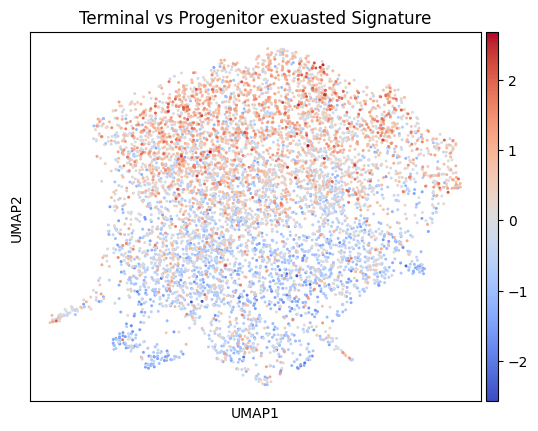

In [25]:
# Terminally exhausted and progenitor exhausted gene signatures
terminal_ex_genes = ["PDCD1", "LAG3", "HAVCR2", "TIGIT", "TOX", "EOMES", "BATF", "ENTPD1", "ITGAE"]
progenitor_ex_genes = ["TCF7", "LEF1", "CXCR5", "IL7R", "SELL", "GZMB", "PRF1", "IFNG", "CD28", "SLAMF6"]

# Filter valid genes in the dataset
terminal_ex_genes_valid = [gene for gene in terminal_ex_genes if gene in cd8_adata.var_names]
progenitor_ex_genes_valid = [gene for gene in progenitor_ex_genes if gene in cd8_adata.var_names]

# Compute scores for each signature
cd8_adata.obs['terminal_ex_score'] = cd8_adata[:, terminal_ex_genes_valid].X.mean(axis=1)
cd8_adata.obs['progenitor_ex_score'] = cd8_adata[:, progenitor_ex_genes_valid].X.mean(axis=1)

# Calculate the difference (terminal vs progenitor)
cd8_adata.obs['ex_score_difference'] = cd8_adata.obs['terminal_ex_score'] - cd8_adata.obs['progenitor_ex_score']

# Plot UMAP with the difference in scores
sc.pl.umap(cd8_adata, color='ex_score_difference', title='Terminal vs Progenitor exuasted Signature', cmap='coolwarm')

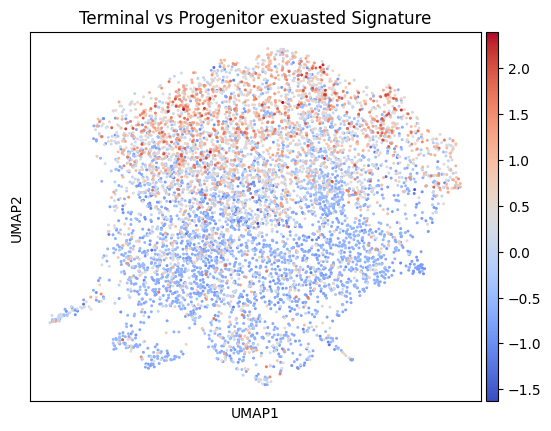

In [5]:
# Terminally exhausted gene signatures
terminal_ex_genes = ["PDCD1", "LAG3", "HAVCR2", "TIGIT", "TOX", "EOMES", "BATF", "ENTPD1", "ITGAE", "LGALS9"]

# Filter valid genes in the dataset
terminal_ex_genes_valid = [gene for gene in terminal_ex_genes if gene in cd8_adata.var_names]

# Compute scores for each signature
cd8_adata.obs['terminal_ex_score'] = cd8_adata[:, terminal_ex_genes_valid].X.mean(axis=1)

# Calculate the difference (terminal vs progenitor)
cd8_adata.obs['ex_score_difference'] = cd8_adata.obs['terminal_ex_score']

# Plot UMAP with the difference in scores
sc.pl.umap(cd8_adata, color='ex_score_difference', title='Terminal vs Progenitor exuasted Signature', cmap='coolwarm')

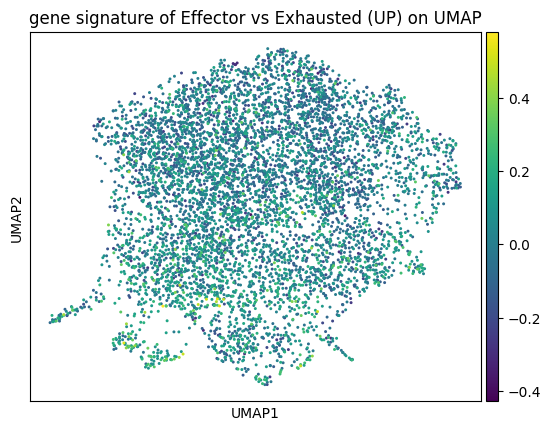

In [20]:
# gene signature (Effector vs Exhausted (UP))
gene_signature_up = [
    "ABCC5", "ABCE1", "ABLIM1", "ACADM", "ACP5", "ADCY7", "ADD1", "ADRB2", "ANAPC16", "ANAPC5", "ANKRD10", "ANTKMT",
    "AP3M1", "API5", "ARFGAP2", "ARMC1", "ATP6V0B", "ATP6V0C", "ATP8A1", "AURKAIP1", "B4GALT1", "BRAP", "C18orf32",
    "C5orf34", "C8orf33", "CACUL1", "CALU", "CCND2", "CCNDBP1", "CCR7", "CCT4", "CCT8", "CDC37", "CHP1", "CLIP1",
    "CLK4", "CNDP2", "CNN3", "CYBC1", "DAP", "DCTN5", "DDC", "DDX50", "DEAF1", "DGKA", "DNAJB1", "DNAJC7", "DUS1L",
    "DYM", "EEIG1", "EIF2B5", "EIF2S1", "EIF3B", "ELOVL5", "EMB", "EML5", "ENG", "EXOSC7", "EYA2", "FAM107B",
    "FARSB", "FBL", "FBXL3", "GABBR1", "GALNT10", "GALNT11", "GFUS", "GGT5", "GHITM", "GIT1", "GLO1", "GM2A",
    "GNPAT", "GSN", "GSTT2", "GTF2I", "HADHB", "HBG2", "HBS1L", "HDAC5", "HEXA", "HPCAL1", "HSD11B1", "IDH2",
    "IFRD2", "IGHM", "IKBKE", "IL7R", "IMPDH2", "INTS9", "IPO4", "ISYNA1", "ITGB7", "ITPA", "JKAMP", "KCNN4", "KLF2",
    "KLK8", "LDAH", "LMAN1", "LRWD1", "LYSMD1", "MAFK", "MAP1LC3B", "MAT2A", "MBP", "MBTPS1", "METTL9", "MLX",
    "MORF4L2", "MRPL37", "MRPS18B", "MTCH1", "NCOA5", "NDEL1", "NSG2", "NSMCE1", "NUDT16L1", "ORC5", "P4HA1",
    "PDE6A", "PHETA1", "PHTF1", "PIGX", "PIK3CD", "PIP4K2A", "PKD1", "PLAC8", "PLP2", "PPDPF", "PPIF", "PRKCB",
    "PRKD2", "PRMT3", "PRPSAP1", "PSAP", "PSMC5", "PSMD13", "PTPN6", "PWP1", "RABGGTA", "RAD17", "RALGPS2", "RAMP1",
    "RBM38", "RERE", "RFLNB", "RGS10", "RNASEH2A", "RNF38", "RNF5", "RNPS1", "RPN1", "RPP25L", "RPRD1A", "RTCB",
    "RUFY1", "S1PR4", "SATB1", "SELENOH", "SELL", "SEMA4A", "SEPTIN6", "SESN1", "SETD6", "SGK1", "SLC1A5", "SLC66A2",
    "SLCO3A1", "SMU1", "SNRNP40", "SNTB1", "SNX6", "SPNS1", "SPTLC1", "SRCAP", "SRP68", "SRPK1", "SS18", "ST13",
    "ST6GAL1", "TBCEL", "TDRP", "TEC", "TIA1", "TIMM44", "TMEM223", "TMEM50B", "TUBB", "TWF2", "TXNL4A", "UBA2",
    "UBR4", "USP24", "USP39", "VPS25", "XIAP", "XPC", "YIPF1", "YIPF3"
]

# Ensure only genes present in the dataset are considered
valid_genes_up = [gene for gene in gene_signature_up if gene in cd8_adata.var_names]

# Compute the average expression of the second signature
cd8_adata.obs['signature_score_up'] = cd8_adata[:, valid_genes_up].X.mean(axis=1)

# Plot the UMAP with the second signature score
sc.pl.umap(cd8_adata, color='signature_score_up', title='gene signature of Effector vs Exhausted (UP)', cmap='viridis')

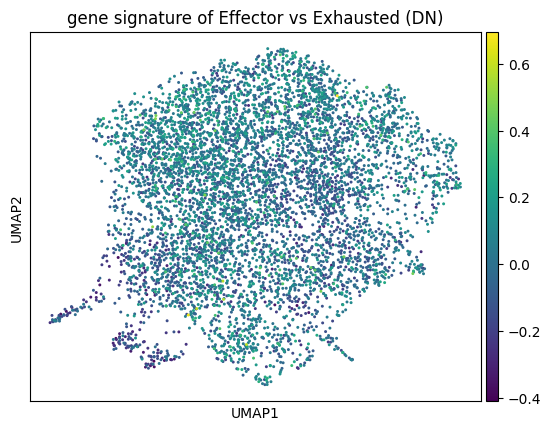

In [21]:
# gene signature (Effector vs Exhausted (DN))

# List of genes in the signature
gene_signature_dn = [
    "ACADVL", "ACSL1", "ADA", "ADAM7", "AFP", "AGAP1", "AHNAK", "ANXA3", "AOPEP", "ARG1", "ATF6", "ATP5MF",
    "AUH", "BAAT", "BCL2A1", "BHLHE40", "BNIP2", "BOP1", "BRS3", "CANX", "CCDC47", "CCDC93", "CCL5", "CCN3",
    "CCR5", "CCRL2", "CD244", "CELF4", "CFH", "CHL1", "CISH", "CIT", "CIZ1", "CKMT2", "CLCA1", "CLDN11",
    "CLIC4", "COCH", "COL19A1", "COPRS", "CORO2B", "CPA3", "CRISP2", "CRYBB2", "CRYZ", "CSF1", "CSRP1",
    "CTLA4", "CTSE", "CXCR3", "CYP2A6", "DMAP1", "DOCK7", "DPP7", "DPT", "DPY30", "DUSP8", "EEA1", "EFHD2",
    "EFNB3", "EIF2AK2", "ENTPD7", "EOMES", "EPCAM", "EPHB6", "ETV1", "F2R", "F2RL1", "FASLG", "FHL1", "FJX1",
    "FRMD5", "GDAP1", "GDNF", "GEM", "GJA1", "GNPTAB", "GPM6B", "GSTM1", "GSTM3", "GTF3C4", "GZMB", "H1-4",
    "H1-5", "H2BC5", "H3C7", "HASPIN", "HCFC1R1", "HCN1", "HINFP", "HMGA2", "HMX3", "HOXC6", "HOXD10", "HTR2C",
    "ID2", "IFNG", "IKZF4", "IL10RA", "IL1A", "IMMT", "KCNAB1", "KCTD9", "KHK", "KLRK1", "KRT27", "LAMC1",
    "LCN2", "LITAF", "LPP-AS2", "LRP10", "MAP2", "MITF", "MMP14", "MOCOS", "MRPL17", "MRPL48", "MRPS18A",
    "MRPS2", "MRPS36", "MYCL", "MYH4", "MYO1F", "MYO6", "MYRF", "NDUFA13", "NELFE", "NQO1", "OSBPL9", "PARP1",
    "PAWR", "PBDC1", "PCLO", "PERP", "PHF7", "PHLDB2", "PLSCR1", "POLD2", "POLR2C", "PRDM1", "PRRC1", "PRXL2A",
    "PTPN12", "PTPRJ", "RAB33B", "RASGRF2", "RBM15", "RELN", "RGS16", "RHAG", "RNF123", "RPA2", "RPS14",
    "S100A13", "SASH1", "SCAND1", "SCN7A", "SCRG1", "SEC14L1", "SERPINB2", "SERPINH1", "SHMT2", "SLC4A7", "SLX9",
    "SNRNP27", "SPOCK2", "ST6GALNAC2", "STRA6", "STX3", "SUB1", "SYPL1", "SYT1", "TBX15", "TCTA", "TERF1",
    "TGM2", "TJP1", "TLN1", "TLR7", "TM4SF1", "TMEM150A", "TMEM266", "TNFRSF1A", "TNFRSF9", "TNFSF10",
    "TNKS1BP1", "TNNI1", "TPK1", "TRPC1", "TRPC6", "TUG1", "UQCC5", "VAMP5", "VAMP7", "VMP1", "XCR1", "YAP1",
    "ZNF35", "ZNF436", "ZNF821"
]

# Ensure only genes present in the dataset are considered
valid_genes_dn = [gene for gene in gene_signature_dn if gene in cd8_adata.var_names]

# Compute the average expression of the signature genes
cd8_adata.obs['signature_score_dn'] = cd8_adata[:, valid_genes_dn].X.mean(axis=1)

# Plot the UMAP with the signature score
sc.pl.umap(cd8_adata, color='signature_score_dn', title='gene signature of Effector vs Exhausted (DN)', cmap='viridis')

## Revised Gene Lists

In [10]:
progenitor_ex_genes = ["TCF7", "LEF1", "CXCR5", "IL7R", "SELL", "SLAMF6", "FOXP1", "STAT4", "AIM1", "FOSL2"]
terminal_ex_genes = ["PDCD1", "LAG3", "HAVCR2", "TIGIT", "TOX", "EOMES", "ENTPD1", "BATF", "LGALS9", "CD38"]

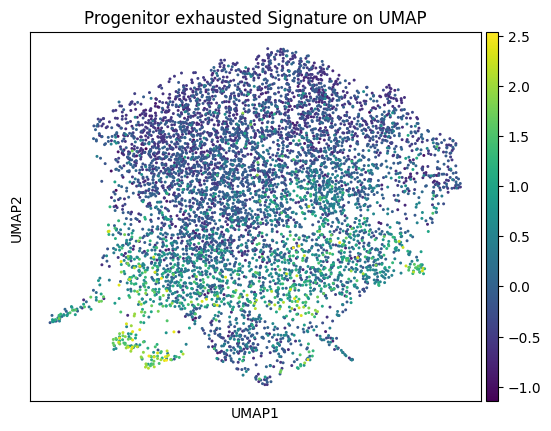

In [11]:
# Filter valid genes in the dataset
progenitor_ex_genes_valid = [gene for gene in progenitor_ex_genes if gene in cd8_adata.var_names]

# Compute the average expression of the progenitor Tex signature
cd8_adata.obs['progenitor_ex_score'] = cd8_adata[:, progenitor_ex_genes_valid].X.mean(axis=1)

# Plot the UMAP with the progenitor Tex signature score
sc.pl.umap(cd8_adata, color='progenitor_ex_score', title='Progenitor exhausted Signature on UMAP', cmap='viridis')

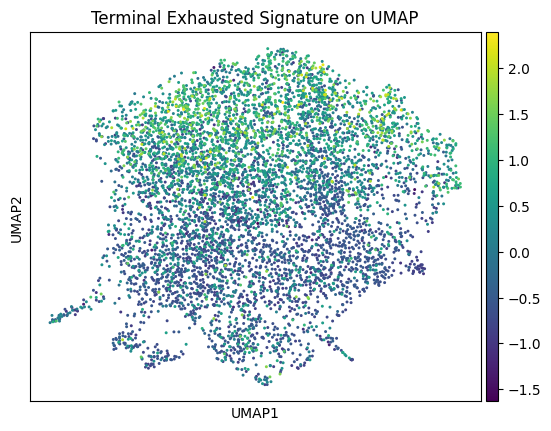

In [5]:
# Filter valid genes in the dataset
terminal_ex_genes_valid = [gene for gene in terminal_ex_genes if gene in cd8_adata.var_names]

# Compute the average expression of the terminal Tex signature
cd8_adata.obs['terminal_ex_score'] = cd8_adata[:, terminal_ex_genes_valid].X.mean(axis=1)

# Plot the UMAP with the terminal Tex signature score
sc.pl.umap(cd8_adata, color='terminal_ex_score', title='Terminal Exhausted Signature on UMAP', cmap='viridis')

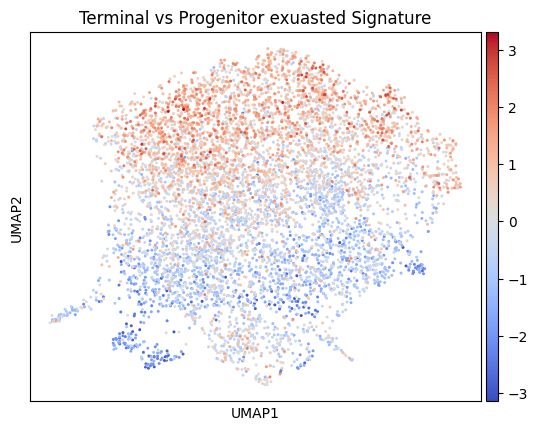

In [6]:
# Filter valid genes in the dataset
terminal_ex_genes_valid = [gene for gene in terminal_ex_genes if gene in cd8_adata.var_names]
progenitor_ex_genes_valid = [gene for gene in progenitor_ex_genes if gene in cd8_adata.var_names]

# Compute scores for each signature
cd8_adata.obs['terminal_ex_score'] = cd8_adata[:, terminal_ex_genes_valid].X.mean(axis=1)
cd8_adata.obs['progenitor_ex_score'] = cd8_adata[:, progenitor_ex_genes_valid].X.mean(axis=1)

# Calculate the difference (terminal vs progenitor)
cd8_adata.obs['ex_score_difference'] = cd8_adata.obs['terminal_ex_score'] - cd8_adata.obs['progenitor_ex_score']

# Plot UMAP with the difference in scores
sc.pl.umap(cd8_adata, color='ex_score_difference', title='Terminal vs Progenitor exuasted Signature', cmap='coolwarm')

## Minimalist Gene List

In [24]:
progenitor_ex_genes = ["TCF7", "IL7R"]
terminal_ex_genes = ["PDCD1", "HAVCR2"]

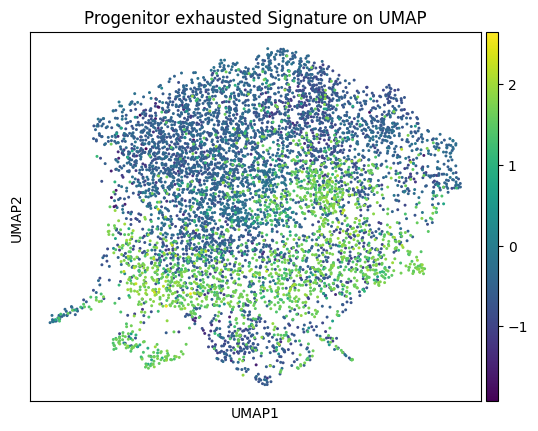

In [19]:
# Filter valid genes in the dataset
progenitor_ex_genes_valid = [gene for gene in progenitor_ex_genes if gene in cd8_adata.var_names]

# Compute the average expression of the progenitor Tex signature
cd8_adata.obs['progenitor_ex_score'] = cd8_adata[:, progenitor_ex_genes_valid].X.mean(axis=1)

# Plot the UMAP with the progenitor Tex signature score
sc.pl.umap(cd8_adata, color='progenitor_ex_score', title='Progenitor exhausted Signature on UMAP', cmap='viridis')

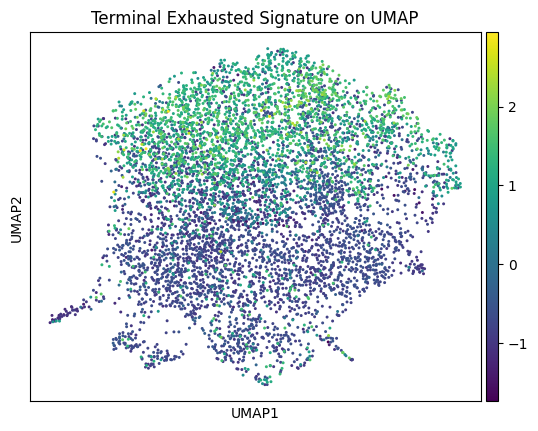

In [25]:
# Filter valid genes in the dataset
terminal_ex_genes_valid = [gene for gene in terminal_ex_genes if gene in cd8_adata.var_names]

# Compute the average expression of the terminal Tex signature
cd8_adata.obs['terminal_ex_score'] = cd8_adata[:, terminal_ex_genes_valid].X.mean(axis=1)

# Plot the UMAP with the terminal Tex signature score
sc.pl.umap(cd8_adata, color='terminal_ex_score', title='Terminal Exhausted Signature on UMAP', cmap='viridis')

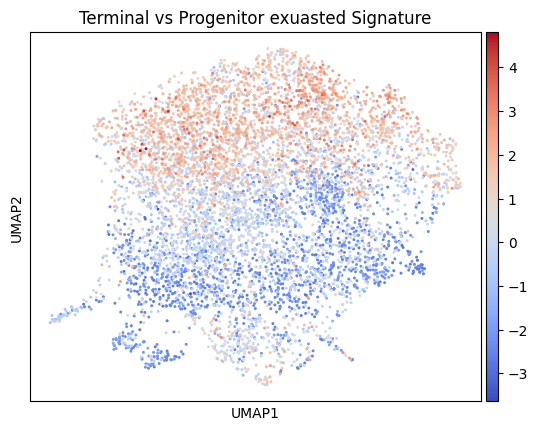

In [21]:
# Filter valid genes in the dataset
terminal_ex_genes_valid = [gene for gene in terminal_ex_genes if gene in cd8_adata.var_names]
progenitor_ex_genes_valid = [gene for gene in progenitor_ex_genes if gene in cd8_adata.var_names]

# Compute scores for each signature
cd8_adata.obs['terminal_ex_score'] = cd8_adata[:, terminal_ex_genes_valid].X.mean(axis=1)
cd8_adata.obs['progenitor_ex_score'] = cd8_adata[:, progenitor_ex_genes_valid].X.mean(axis=1)

# Calculate the difference (terminal vs progenitor)
cd8_adata.obs['ex_score_difference'] = cd8_adata.obs['terminal_ex_score'] - cd8_adata.obs['progenitor_ex_score']

# Plot UMAP with the difference in scores
sc.pl.umap(cd8_adata, color='ex_score_difference', title='Terminal vs Progenitor exuasted Signature', cmap='coolwarm')

### Gene Expression Distributions

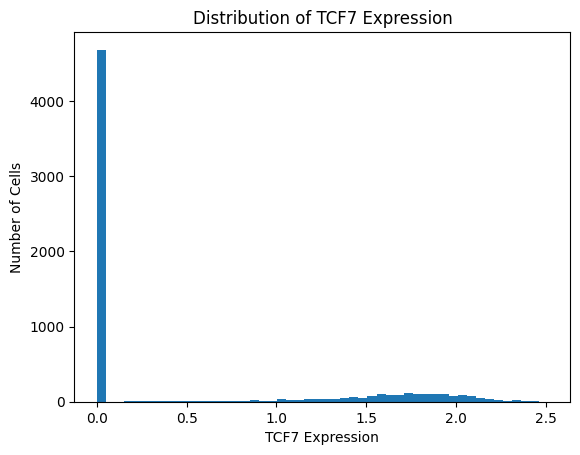

In [30]:
# TCF7
# Extract TCF7 expression values from the raw data
TCF7_expression = cd8_adata.raw[:, 'TCF7'].X.flatten()

# Plot the distribution of TCF7 expression values
plt.hist(TCF7_expression, bins=50)
plt.xlabel('TCF7 Expression')
plt.ylabel('Number of Cells')
plt.title('Distribution of TCF7 Expression')
plt.show()

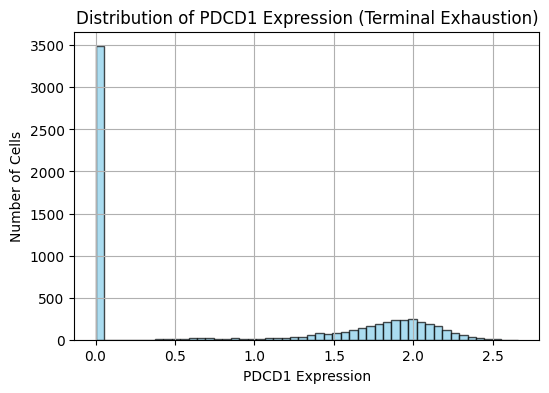

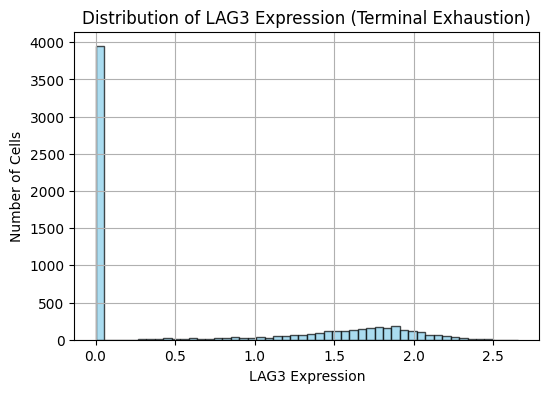

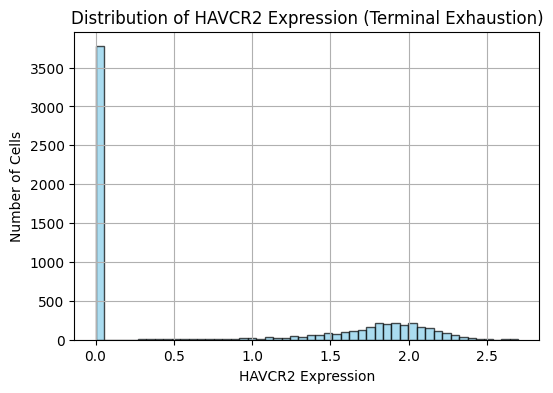

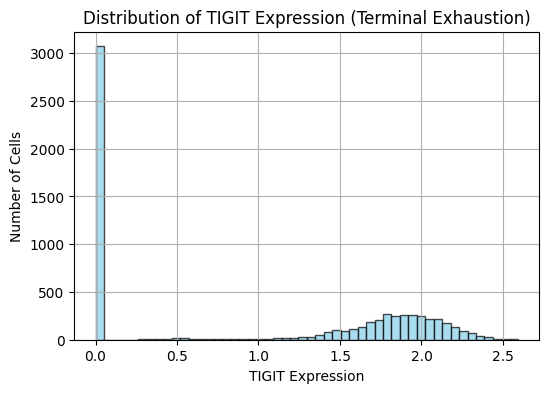

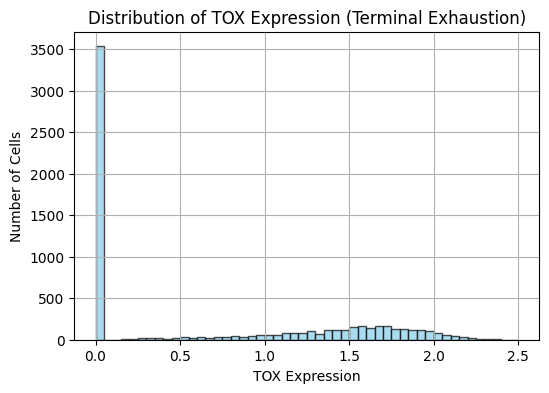

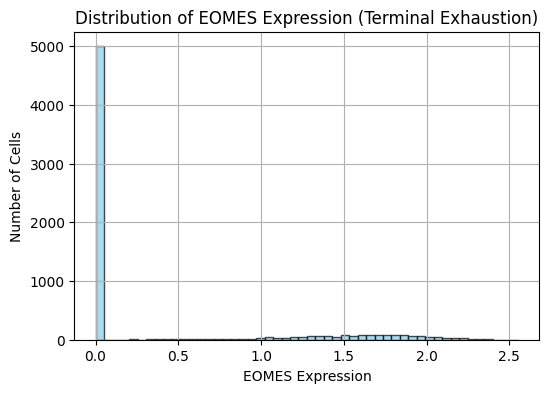

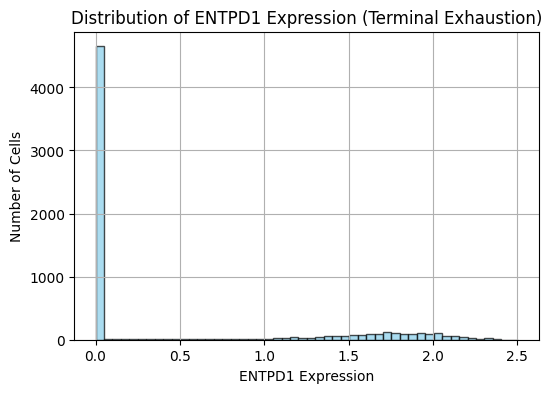

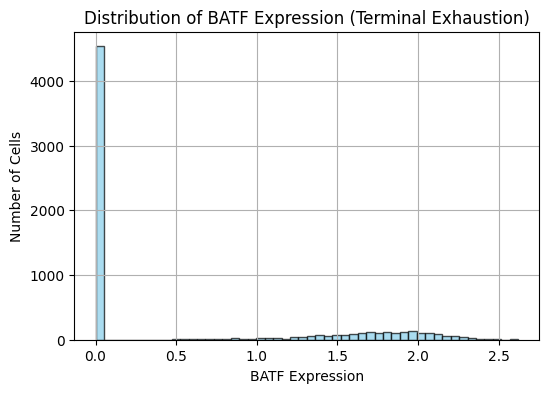

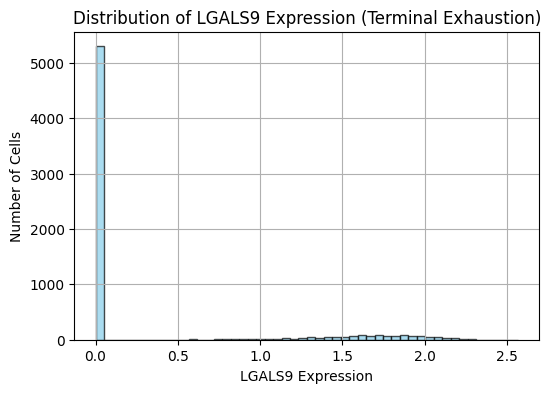

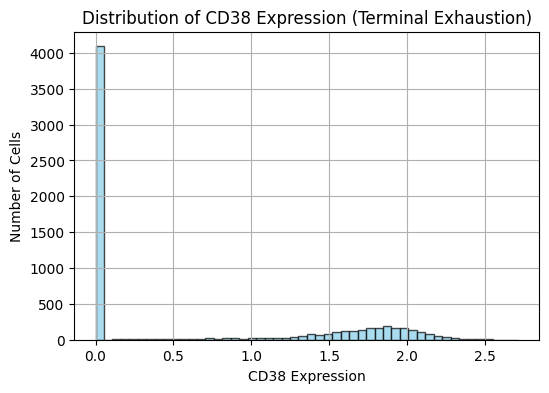

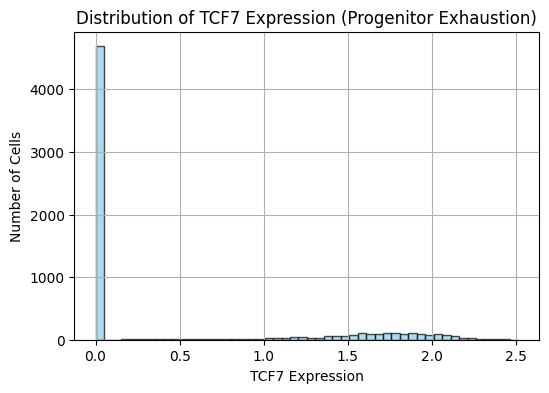

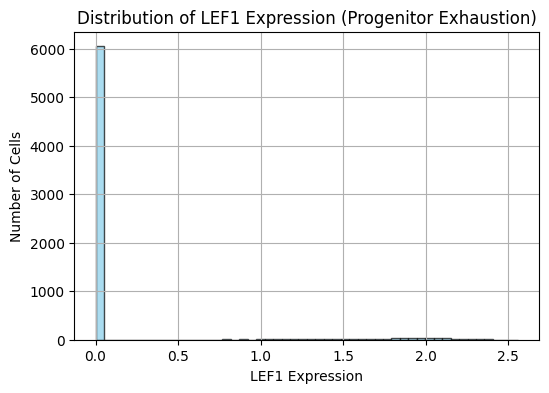

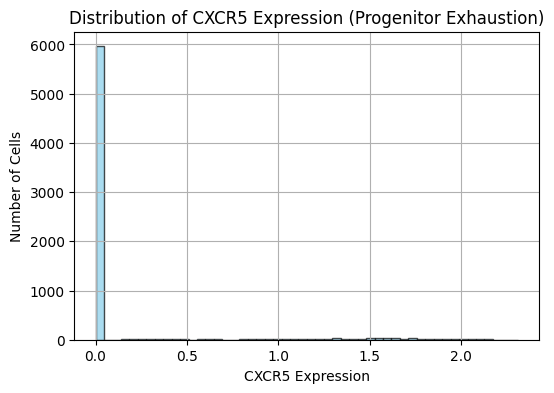

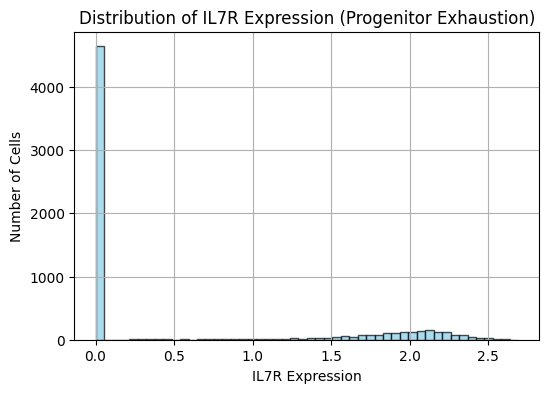

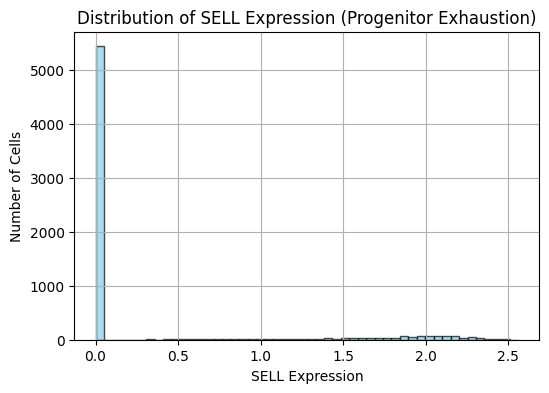

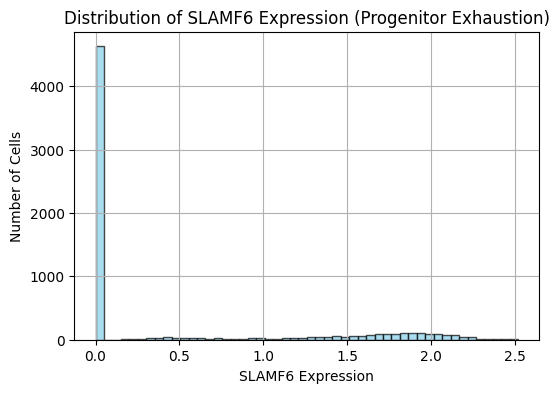

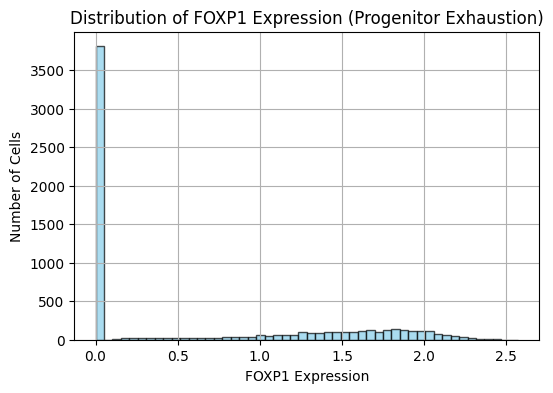

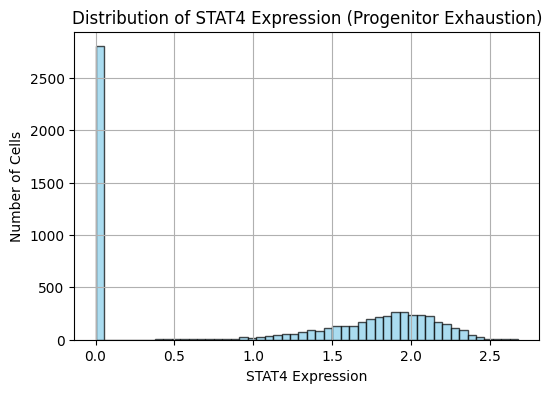

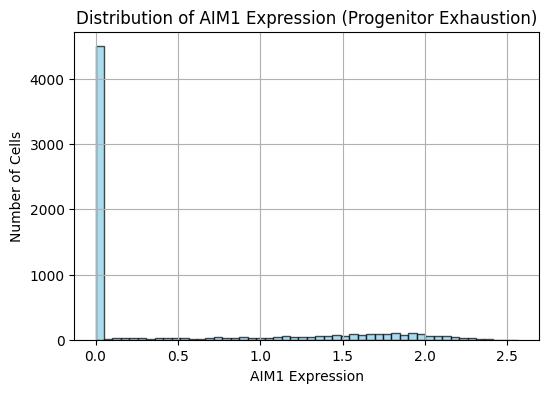

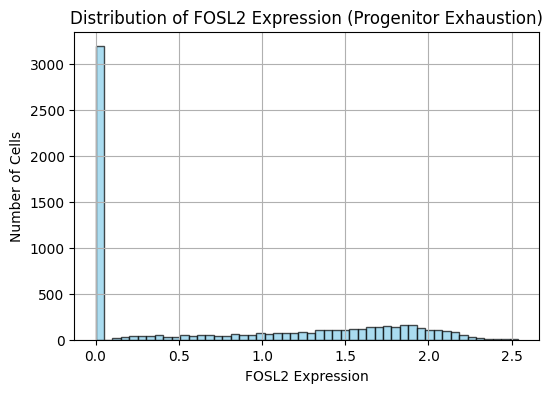

In [7]:
# Gene lists
progenitor_ex_genes = ["TCF7", "LEF1", "CXCR5", "IL7R", "SELL", "SLAMF6", "FOXP1", "STAT4", "AIM1", "FOSL2"]
terminal_ex_genes = ["PDCD1", "LAG3", "HAVCR2", "TIGIT", "TOX", "EOMES", "ENTPD1", "BATF", "LGALS9", "CD38"]

# Function to plot the distribution of gene expression
def plot_gene_expression(adata, gene_list, group_name):
    for gene in gene_list:
        if gene in adata.raw.var_names:  # Check if the gene exists in the dataset
            expression_values = adata.raw[:, gene].X.flatten()
            plt.figure(figsize=(6, 4))
            plt.hist(expression_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
            plt.xlabel(f'{gene} Expression')
            plt.ylabel('Number of Cells')
            plt.title(f'Distribution of {gene} Expression ({group_name})')
            plt.grid(True)
            plt.show()
        else:
            print(f"Gene {gene} not found in the dataset.")

# Plot distributions for terminal exhaustion genes
plot_gene_expression(cd8_adata, terminal_ex_genes, "Terminal Exhaustion")

# Plot distributions for progenitor exhaustion genes
plot_gene_expression(cd8_adata, progenitor_ex_genes, "Progenitor Exhaustion")